In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io.wavfile import read, write
from pydub import AudioSegment
import io


c:\Users\Muhammad Zaky T A\AppData\Local\Programs\Python\Python311\Lib\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


In [2]:
def load_audio(filename):
    audio = AudioSegment.from_wav(filename)
    samples = np.array(audio.get_array_of_samples(), dtype=np.float32)
    samples /= np.max(np.abs(samples))  # Normalisasi ke -1 hingga 1
    return samples, audio.frame_rate

# Fungsi untuk menyimpan audio
def save_audio(filename, samples, frame_rate):
    scaled_samples = np.int16(samples / np.max(np.abs(samples)) * 32767)  # Normalisasi ke 16-bit
    write(filename, frame_rate, scaled_samples)

# Muat kedua file audio
noisy_signal, fs_noisy = load_audio('audio1.wav')
clean_signal, fs_clean = load_audio('sp01.wav')

# Pastikan sample rate kedua file sama
assert fs_noisy == fs_clean

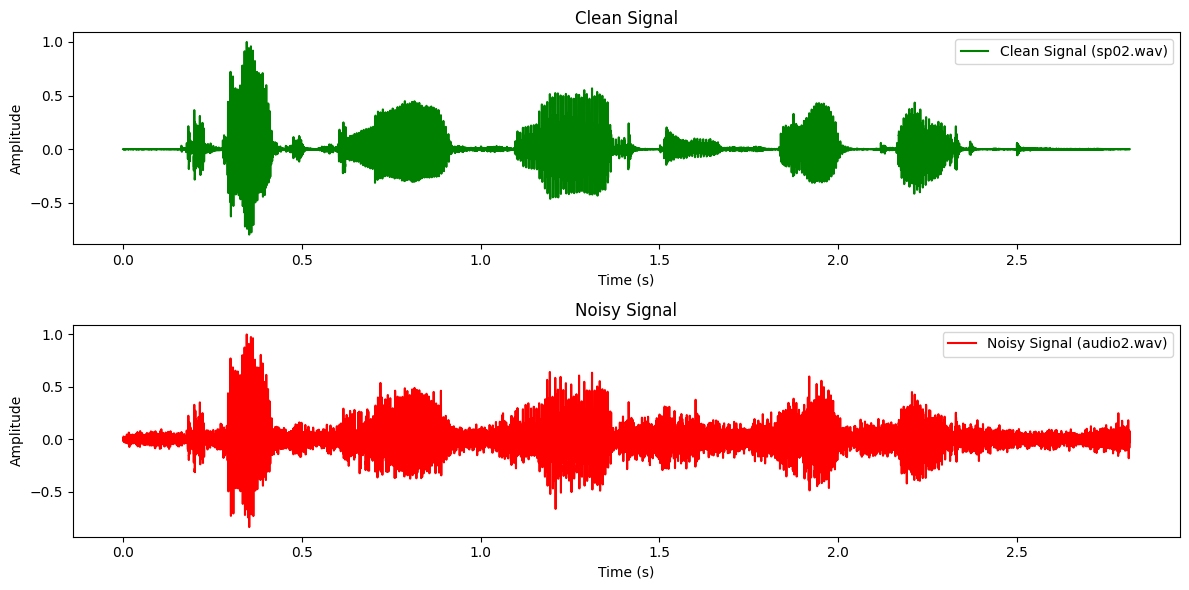

In [3]:
def plot_signals(clean_signal, noisy_signal, fs):
    t = np.linspace(0, len(clean_signal) / fs, len(clean_signal))
    plt.figure(figsize=(12, 6))
    plt.subplot(2, 1, 1)
    plt.plot(t, clean_signal, label='Clean Signal (sp02.wav)', color='green')
    plt.title("Clean Signal")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(t, noisy_signal, label='Noisy Signal (audio2.wav)', color='red')
    plt.title("Noisy Signal")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.legend()

    plt.tight_layout()
    plt.show()

# Tampilkan plot sinyal
plot_signals(clean_signal, noisy_signal, fs_noisy)

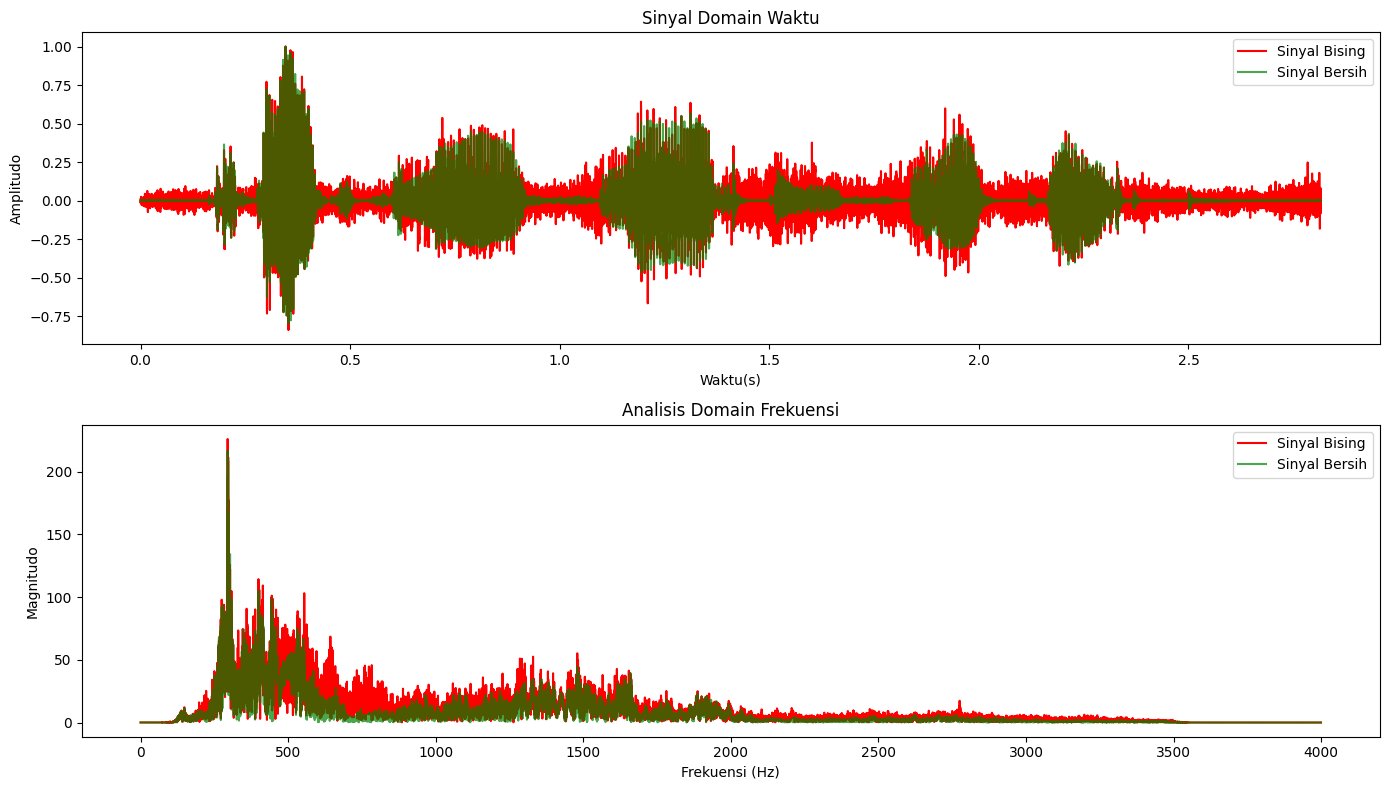

In [4]:
from scipy.fft import fft, fftfreq

# Compute FFT for frequency domain analysis
def compute_fft(signal, fs):
    N = len(signal)
    yf = fft(signal)
    xf = fftfreq(N, 1 / fs)
    return xf[:N // 2], np.abs(yf[:N // 2])  # Return positive frequencies

noisy_freq, noisy_magnitude = compute_fft(noisy_signal, fs_noisy)
clean_freq, clean_magnitude = compute_fft(clean_signal, fs_clean)

# Plot time-domain signals
plt.figure(figsize=(14, 8))
time = np.linspace(0, len(noisy_signal) / fs_noisy, len(noisy_signal))

# Time-domain signals
plt.subplot(2, 1, 1)
plt.plot(time, noisy_signal, label="Sinyal Bising", color="red")
plt.plot(time, clean_signal, label="Sinyal Bersih", color="green", alpha=0.7)
plt.title("Sinyal Domain Waktu")
plt.xlabel("Waktu(s)")
plt.ylabel("Amplitudo")
plt.legend()

# Frequency-domain signals
plt.subplot(2, 1, 2)
plt.plot(noisy_freq, noisy_magnitude, label="Sinyal Bising", color="red")
plt.plot(clean_freq, clean_magnitude, label="Sinyal Bersih", color="green", alpha=0.7)
plt.title("Analisis Domain Frekuensi")
plt.xlabel("Frekuensi (Hz)")
plt.ylabel("Magnitudo")
plt.legend()

plt.tight_layout()
plt.show()


In [5]:
def lms_filter(noisy_signal, clean_signal, mu=0.1,n_taps=32):
    n_samples = len(noisy_signal)
    w = np.zeros(n_taps)  # Inisialisasi koefisien filter
    y = np.zeros(n_samples)  # Output sinyal hasil filter
    e = np.zeros(n_samples)  # Error signal

    for n in range(n_taps, n_samples):
        x_n = noisy_signal[n-n_taps:n]  # Masukan ke filter
        y[n] = np.dot(w, x_n)  # Output filter
        e[n] = clean_signal[n] - y[n]  # Error signal
        w += 2 * mu * e[n] * x_n  # Pembaruan koefisien filter
    return y, e

# Terapkan LMS Filter
lms_output, error_signal = lms_filter(noisy_signal, clean_signal)

# Simpan hasil ke file
save_audio("lms_filtered.wav", lms_output, fs_noisy)

In [6]:
def nlms_filter(noisy_signal, clean_signal, mu=0.1, n_taps=32, eps=1e-10):
    # mu: step size yang lebih besar untuk konvergensi lebih cepat
    # n_taps: panjang filter yang cukup untuk menangkap karakteristik noise
    # eps: parameter stabilitas untuk mencegah pembagian dengan nol:
    
    n_samples = len(noisy_signal)
    w = np.zeros(n_taps)  # Inisialisasi koefisien filter
    y = np.zeros(n_samples)  # Output filter
    e = np.zeros(n_samples)  # Error signal

    for n in range(n_taps, n_samples):
        x_n = noisy_signal[n-n_taps:n]  # Masukan filter
        energy = np.dot(x_n, x_n)  # Energi input sinyal
        if energy > 0:  # Hindari pembagian dengan nol
            mu_eff = mu / energy  # Sesuaikan step size dengan energi input
        else:
            mu_eff = mu

        y[n] = np.dot(w, x_n)  # Output filter
        e[n] = clean_signal[n] - y[n]  # Error antara sinyal bersih dan output filter
        w += 2 * mu_eff * e[n] * x_n  # Pembaruan koefisien filter
    return y, e

# Terapkan filter NLMS pada sinyal noisy
nlms_output, nlms_error = nlms_filter(noisy_signal, clean_signal)

# Simpan hasil ke file
save_audio("nlms_filtered.wav", nlms_output, fs_noisy)



In [7]:
def rls_filter(noisy_signal,clean_signal,delta=1e-3,n_taps=32):
    n_samples = len(noisy_signal)
    w = np.zeros(n_taps)  # Inisialisasi koefisien filter
    P = np.eye(n_taps) / delta  # Matriks invers covariance (regularization)
    y = np.zeros(n_samples)  # Output filter
    e = np.zeros(n_samples)  # Error signal

    for n in range(n_taps, n_samples):
        x_n = noisy_signal[n-n_taps:n]  # Masukan filter
        k = P @ x_n / (1 + x_n.T @ P @ x_n)  # Kalman gain
        y[n] = np.dot(w, x_n)  # Output filter
        e[n] = clean_signal[n] - y[n]  # Error antara sinyal bersih dan output filter
        w += k * e[n]  # Pembaruan koefisien filter
        P = (P - np.outer(k, x_n) @ P) / (1 + x_n.T @ P @ x_n)  # Update matriks P
    return y, e

# Terapkan filter RLS pada sinyal noisy
rls_output, rls_error = rls_filter(noisy_signal, clean_signal)

# Simpan hasil ke file
save_audio("rls_filtered.wav", rls_output, fs_noisy)


In [8]:
def calculate_mse(clean_signal, filtered_signal):
    return np.mean((clean_signal - filtered_signal) ** 2)

def calculate_snr(clean_signal, filtered_signal):
    noise = clean_signal - filtered_signal
    signal_power = np.sum(clean_signal ** 2)
    noise_power = np.sum(noise ** 2)
    snr = 10 * np.log10(signal_power / noise_power)
    return snr

In [9]:
# Hitung MSE
mse_lms = calculate_mse(clean_signal, lms_output)
mse_nlms = calculate_mse(clean_signal, nlms_output) 
mse_rls = calculate_mse(clean_signal, rls_output)

# Hitung SNR
snr_lms = calculate_snr(clean_signal, lms_output)
snr_nlms = calculate_snr(clean_signal, nlms_output)
snr_rls = calculate_snr(clean_signal, rls_output)

# Tampilkan hasil evaluasi
print("Mean Square Error (MSE):")
print(f"LMS: {mse_lms:.6f}")
print(f"NLMS: {mse_nlms:.6f}") 
print(f"RLS: {mse_rls:.6f}")

print("\nSignal-to-Noise Ratio (SNR):")
print(f"LMS: {snr_lms:.2f} dB")
print(f"NLMS: {snr_nlms:.2f} dB")
print(f"RLS: {snr_rls:.2f} dB")

Mean Square Error (MSE):
LMS: 0.001755
NLMS: 0.001632
RLS: 0.006203

Signal-to-Noise Ratio (SNR):
LMS: 7.68 dB
NLMS: 7.99 dB
RLS: 2.19 dB


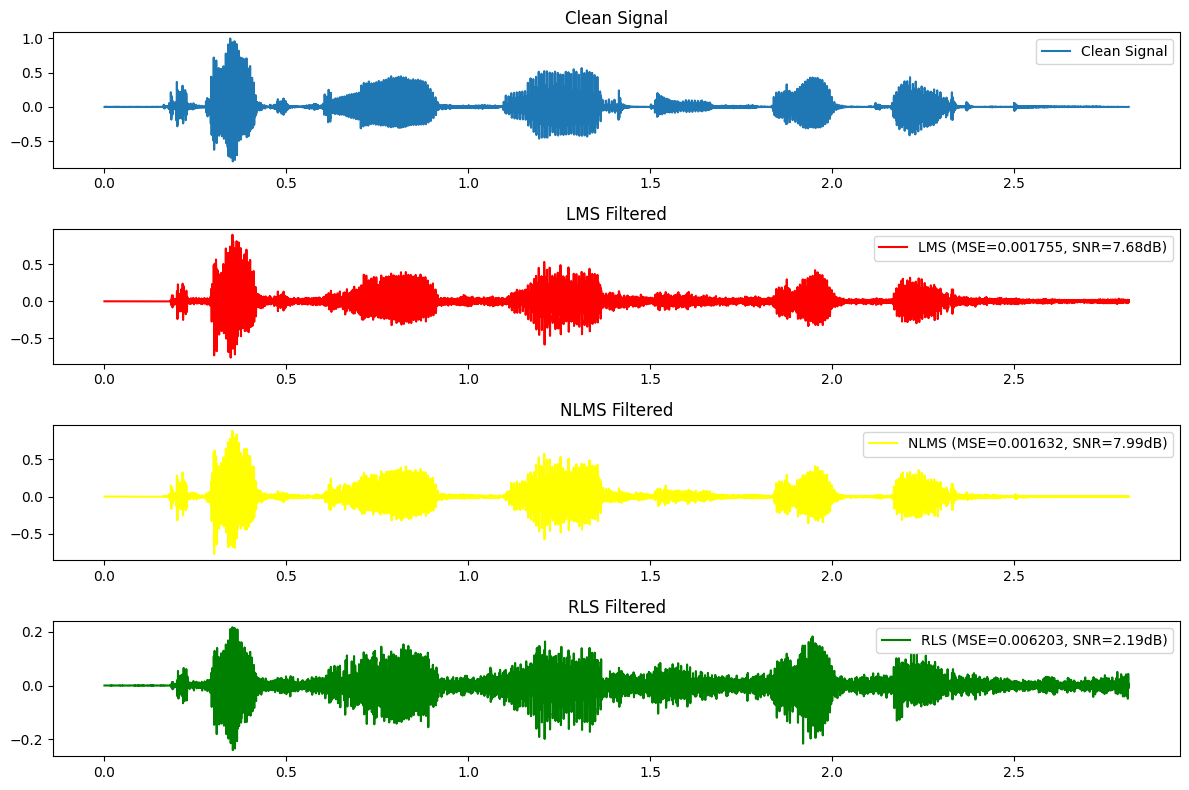

In [11]:
# Plot perbandingan hasil filtering
plt.figure(figsize=(12, 8))
t = np.linspace(0, len(clean_signal)/fs_clean, len(clean_signal))

plt.subplot(4,1,1)
plt.plot(t, clean_signal, label='Clean Signal')
plt.title('Clean Signal')
plt.legend()

plt.subplot(4,1,2)
plt.plot(t, lms_output, label=f'LMS (MSE={mse_lms:.6f}, SNR={snr_lms:.2f}dB)', color ="red")
plt.title('LMS Filtered')
plt.legend()

plt.subplot(4,1,3)
plt.plot(t, nlms_output, label=f'NLMS (MSE={mse_nlms:.6f}, SNR={snr_nlms:.2f}dB)', color ="yellow")
plt.title('NLMS Filtered')
plt.legend()

plt.subplot(4,1,4)
plt.plot(t, rls_output, label=f'RLS (MSE={mse_rls:.6f}, SNR={snr_rls:.2f}dB)', color ="green")
plt.title('RLS Filtered')
plt.legend()

plt.tight_layout()
plt.show()